# Finals Reviewer

In [125]:
!pip install -q tensorflow


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [126]:
import time
import random 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from itertools import product
from typing import Optional, Union, List, Tuple, Dict, Any

# sklearn
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score

# ARIMA related imports
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

## ARIMA

**AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.  
**I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.  
**MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.  

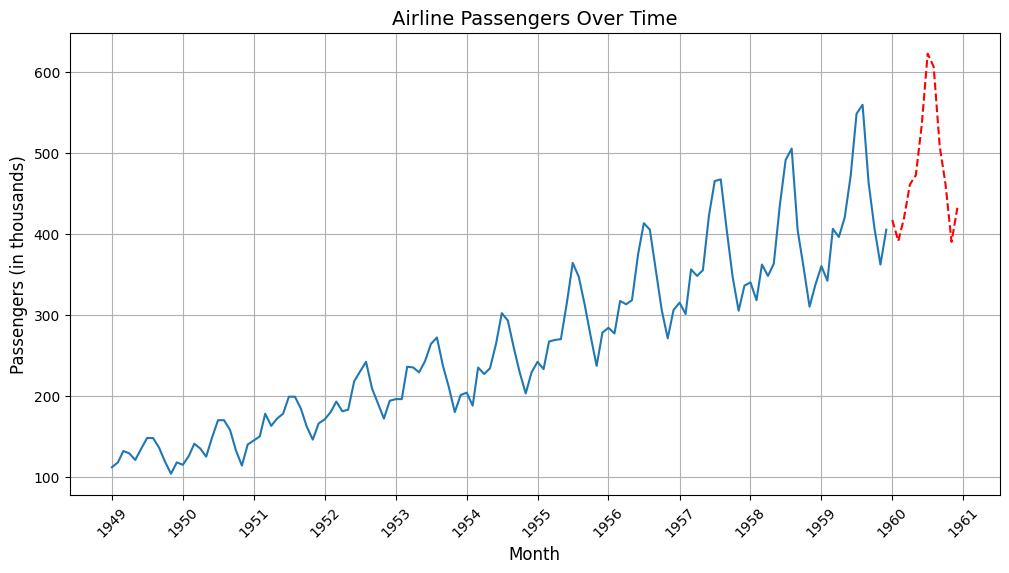

In [4]:
df = pd.read_csv("../../data/international-airline-passengers.csv")
df = df.iloc[:-1]
df.columns = ["month", "passengers_thousands"]

df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

train_df = df[df["month"].dt.year<1960]
val_df = df[df["month"].dt.year==1960]

years = list(df["month"].dt.year.unique())
years.append(max(years) + 1)

plt.figure(figsize=(12, 6))
plt.plot(train_df["month"], train_df["passengers_thousands"])
plt.plot(val_df["month"], val_df["passengers_thousands"], color="r", linestyle="--")
plt.xticks(
    ticks=pd.to_datetime([f"{year}-01-01" for year in years]), 
    labels=years, 
    rotation=45  # Rotate for better readability if needed
)
plt.title("Airline Passengers Over Time", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers (in thousands)", fontsize=12)
plt.grid(True)
plt.show()

### (1) Create deseasonalized dataset

In [6]:
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = float(dataset[i] - dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

ADF Statistic: -3.048011
p-value: 0.030648
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


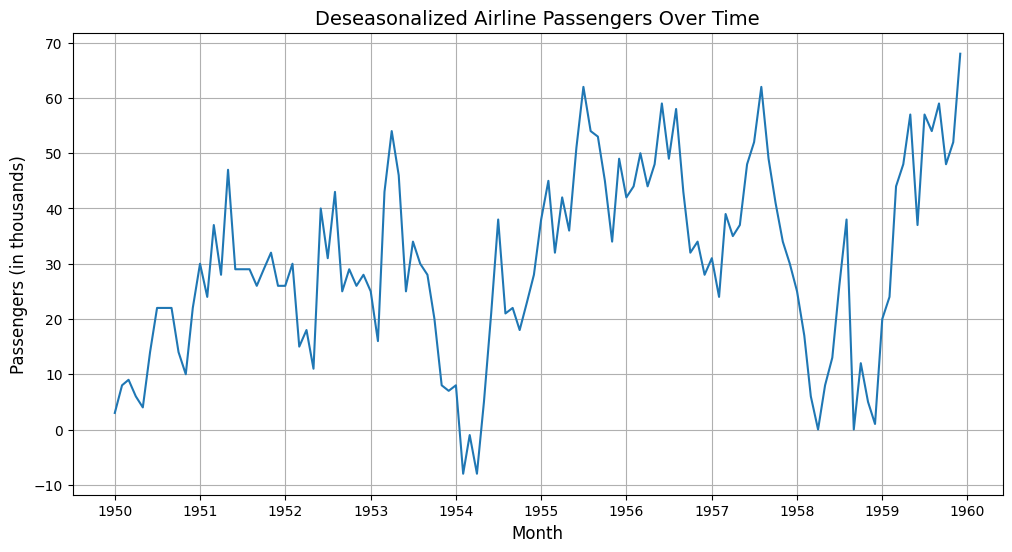

In [7]:
X = train_df["passengers_thousands"]
months_in_year = 12

stationary = difference(X, months_in_year)
stationary.index = train_df["month"][months_in_year:]

result = adfuller(stationary)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

plt.figure(figsize=(12, 6))
plt.plot(stationary.index, stationary)
plt.title("Deseasonalized Airline Passengers Over Time", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Passengers (in thousands)", fontsize=12)
plt.grid(True)
plt.show()

Given that the ADF statistic is `-3.048011` is smaller than the p-value `0.030648`, the system has no unit root and is therefore stationary.

### (2) Select lag values for AR and MA

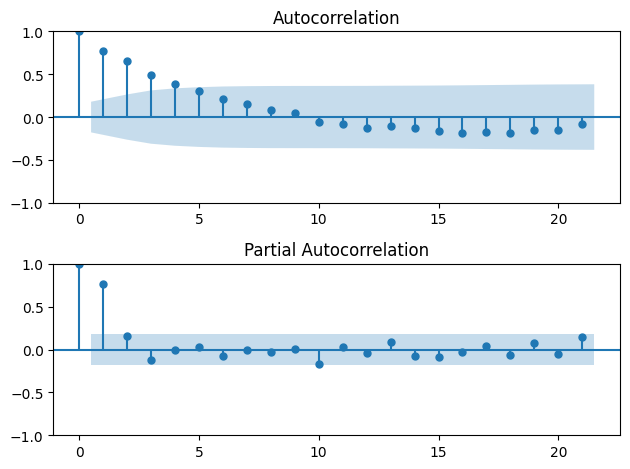

In [9]:
plt.figure()

# Plot ACF (Autocorrelation Function) in the first subplot
plt.subplot(211)
plot_acf(stationary, ax=plt.gca())

# Plot PACF (Partial Autocorrelation Function) in the second subplot
plt.subplot(212)
plot_pacf(stationary, ax=plt.gca())

# Show the plots
plt.tight_layout()  # Ensure no overlapping between plots
plt.show()

### (3) ARIMA modeling

In [11]:
def inverse_difference(history, yhat, interval=1):
	return float(yhat + history[-interval])

In [12]:
X.index = train_df["month"]

In [13]:
# Default ARIMA order
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = []
months_in_year = 12

for i in range(len(test)):
    diff = difference(history, months_in_year)
    
    model = ARIMA(diff)
    model_fit = model.fit()
    
    forecast = model_fit.forecast()
    
    yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
    predictions.append(yhat)
    
    obs = test[i]
    history.append(obs)
    print(f">Predicted={yhat:.3f}, Expected={obs:.3f}")

>Predicted=336.065, Expected=347.000
>Predicted=301.181, Expected=305.000
>Predicted=336.221, Expected=336.000
>Predicted=345.219, Expected=340.000
>Predicted=331.165, Expected=318.000
>Predicted=386.031, Expected=362.000
>Predicted=377.788, Expected=348.000
>Predicted=384.490, Expected=363.000
>Predicted=451.277, Expected=435.000
>Predicted=494.118, Expected=491.000
>Predicted=496.087, Expected=505.000
>Predicted=433.173, Expected=404.000
>Predicted=375.895, Expected=359.000
>Predicted=333.736, Expected=310.000
>Predicted=364.514, Expected=337.000
>Predicted=368.259, Expected=360.000
>Predicted=346.183, Expected=342.000
>Predicted=390.145, Expected=406.000
>Predicted=376.288, Expected=396.000
>Predicted=391.464, Expected=420.000
>Predicted=463.717, Expected=472.000
>Predicted=519.789, Expected=548.000
>Predicted=534.035, Expected=559.000
>Predicted=433.250, Expected=463.000
>Predicted=388.504, Expected=407.000
>Predicted=339.661, Expected=362.000
>Predicted=366.849, Expected=405.000


RMSE: 20.441
MAE: 17.816


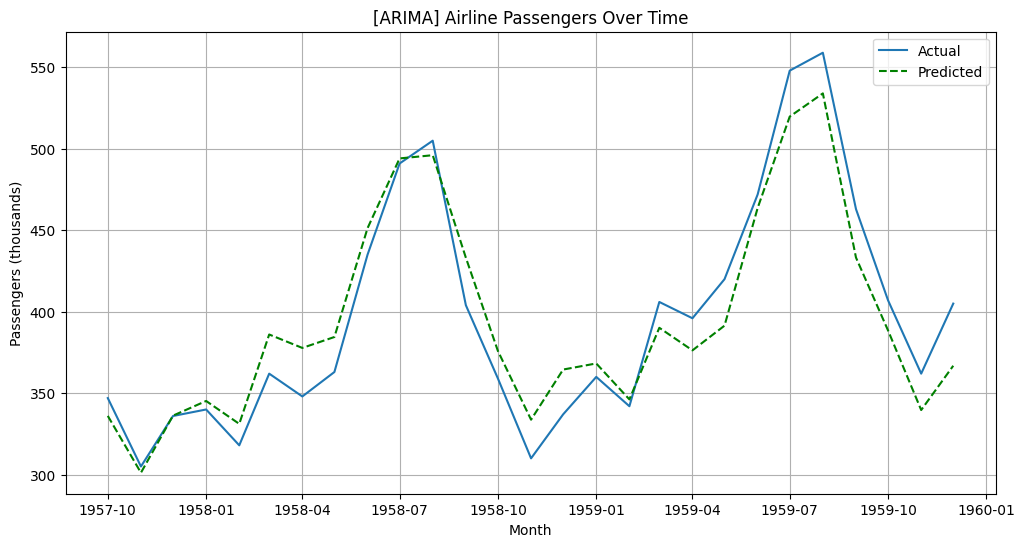

In [14]:
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mse)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test, label="Actual",)
plt.plot(test.index, predictions, label="Predicted", linestyle="--", color="green")

plt.title("[ARIMA] Airline Passengers Over Time")
plt.xlabel("Month")
plt.ylabel("Passengers (thousands)")

plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Find optimal (p, d, q)

def evaluate_arima_model(
    X: Union[List[float], np.ndarray, pd.Series],
    order: Tuple[int, int, int],
    y: Optional[Union[List[float], np.ndarray, pd.Series]] = None,
    validation: bool = False,
) -> Union[float, Tuple[float, List[float]]]:
    
    if validation:
        history = [x for x in X]
        months_in_year = 12

        results = {}
        predictions = []

        model = ARIMA(X, order=order)
        model_fit = model.fit()

        forecast = model_fit.forecast()

        yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
        predictions.append(yhat)

        history.append(y[0])
        print(">Predicted=%.3f, Expected=%.3f" % (yhat, y[0]))

        start_time = time.perf_counter()
        for t in range(1, len(y)):
            diff = difference(history, months_in_year)

            model = ARIMA(diff, order=order)
            model_fit = model.fit()

            forecast = model_fit.forecast()

            yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
            predictions.append(yhat)

            obs = y[t]
            history.append(obs)
            
            print(">Predicted=%.3f, Expected=%.3f" % (yhat, obs))
        end_time = time.perf_counter()

        mse = mean_squared_error(y, predictions)
        rmse = sqrt(mse)

        mae = mean_absolute_error(y, predictions)
        results["rmse"] = rmse
        results["mae"] = mae
        results["runtime"] = end_time - start_time
        results["y"] = y
        results["yhat"] = predictions

        return results

    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    months_in_year = 12

    results = {}
    predictions = []

    start_time = time.perf_counter()
    for t in range(len(test)):
        diff = difference(history, months_in_year)

        model = ARIMA(diff, order=order)
        model_fit = model.fit()
        
        forecast = model_fit.forecast()

        yhat = inverse_difference(history, forecast.iloc[0], months_in_year)
        predictions.append(yhat)

        obs = test[t]
        history.append(obs)
    end_time = time.perf_counter()

    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)

    mae = mean_absolute_error(test, predictions)

    results["rmse"] = rmse
    results["mae"] = mae
    results["runtime"] = end_time - start_time
    results["y"] = test
    results["yhat"] = predictions
 
    return results


In [17]:
p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

rmse_results = {}
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    results = evaluate_arima_model(X=X, order=order)

    rmse = results["rmse"]
    rmse_results[order] = rmse

    print(f"Order {order}, RMSE: {rmse}")

Order (0, 0, 0), RMSE: 20.441192779160826
Order (0, 0, 1), RMSE: 16.034744490537914
Order (0, 0, 2), RMSE: 14.146867901706312
Order (0, 0, 3), RMSE: 12.892284126394543
Order (0, 1, 0), RMSE: 12.954335753515686
Order (0, 1, 1), RMSE: 12.940213947883132
Order (0, 1, 2), RMSE: 13.074519353916678
Order (0, 1, 3), RMSE: 12.957654457806228
Order (1, 0, 0), RMSE: 12.643366326086309
Order (1, 0, 1), RMSE: 12.661678817142985
Order (1, 0, 2), RMSE: 12.477491172614588
Order (1, 0, 3), RMSE: 12.657723945105973
Order (1, 1, 0), RMSE: 12.815013904026102
Order (1, 1, 1), RMSE: 12.776372237744456
Order (1, 1, 2), RMSE: 12.880982409632043
Order (1, 1, 3), RMSE: 13.105949331165279
Order (2, 0, 0), RMSE: 12.62485796728145
Order (2, 0, 1), RMSE: 12.74134552776835
Order (2, 0, 2), RMSE: 12.537240268412372
Order (2, 0, 3), RMSE: 12.65976843270022
Order (2, 1, 0), RMSE: 12.848654233381183
Order (2, 1, 1), RMSE: 12.865468671209891
Order (2, 1, 2), RMSE: 12.735781187930307
Order (2, 1, 3), RMSE: 13.29078474674

In [18]:
best_order = min(rmse_results, key=rmse_results.get)
best_rmse = rmse_results[best_order]

print(f"\nBest Order: {best_order}, Lowest RMSE: {best_rmse}")


Best Order: (1, 0, 2), Lowest RMSE: 12.477491172614588


               0
count  27.000000
mean    1.017615
std    12.672822
min   -38.197029
25%    -5.784505
50%     2.560830
75%     8.569044
max    23.457425


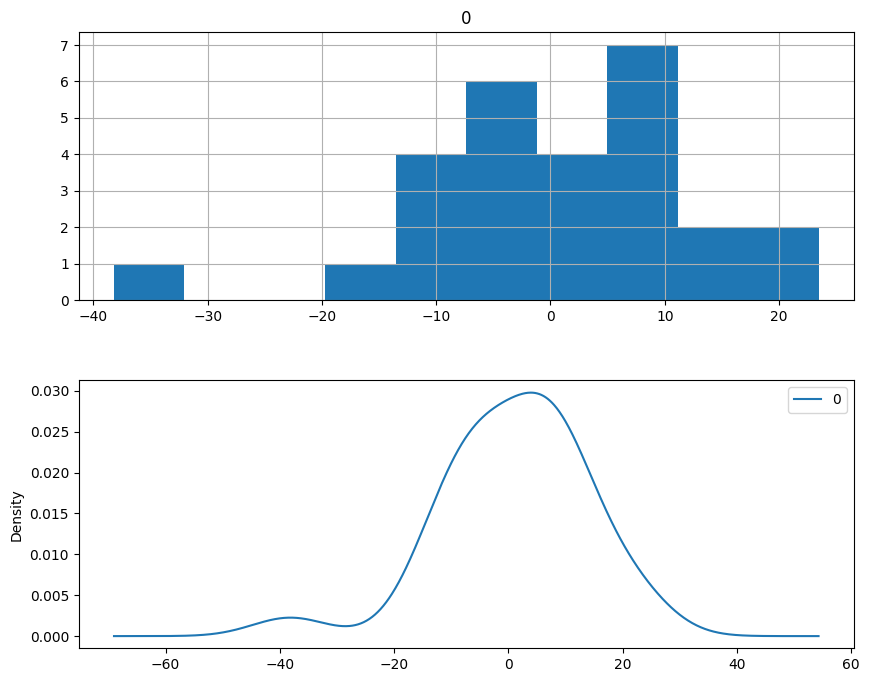

In [19]:
results = evaluate_arima_model(X=X, order=best_order)

test, predictions = results["y"], results["yhat"]

residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

plt.figure(figsize=(10, 8))

plt.subplot(211)
residuals.hist(ax=plt.gca())

plt.subplot(212)
residuals.plot(kind="kde", ax=plt.gca())

plt.show()

### (4) ARIMA validation

In [20]:
val = val_df["passengers_thousands"]
val.index = val_df["month"]

arima_results = evaluate_arima_model(X=X, y=val, order=best_order, validation=True)

>Predicted=796.657, Expected=417.000
>Predicted=397.654, Expected=391.000
>Predicted=450.321, Expected=419.000
>Predicted=409.434, Expected=461.000
>Predicted=466.140, Expected=472.000
>Predicted=524.103, Expected=535.000
>Predicted=603.656, Expected=622.000
>Predicted=623.475, Expected=606.000
>Predicted=511.628, Expected=508.000
>Predicted=446.064, Expected=461.000
>Predicted=408.794, Expected=390.000
>Predicted=438.783, Expected=432.000


RMSE: 111.525
MAE: 47.160
Runtime: 0.544


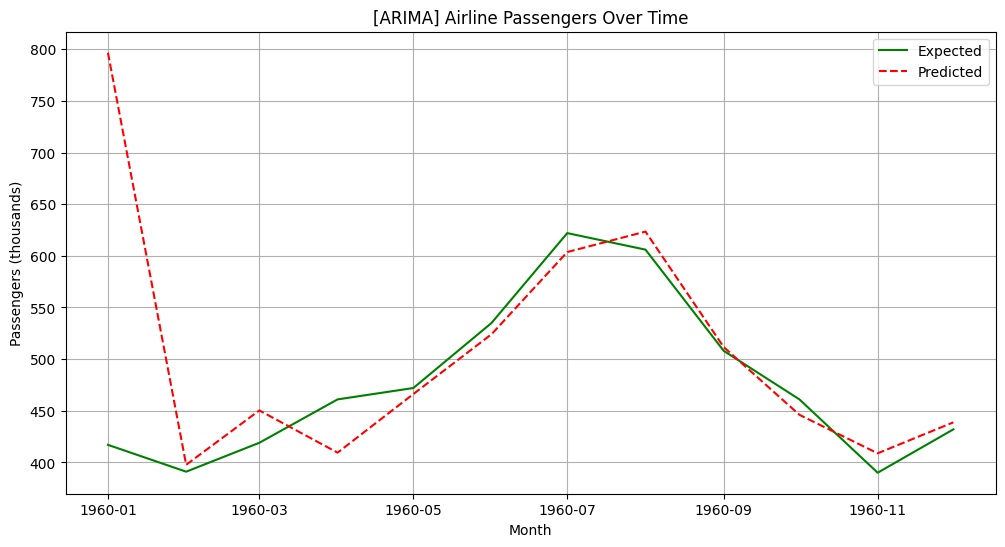

In [21]:
print("RMSE: %.3f" % arima_results["rmse"])
print("MAE: %.3f" % arima_results["mae"])
print("Runtime: %.3f" % arima_results["runtime"])

predictions = pd.Series(arima_results["yhat"])
predictions.index = val.index

plt.figure(figsize=(12, 6))
plt.plot(val, label='Expected', color="green")
plt.plot(predictions, color='red', linestyle="--", label='Predicted')

plt.title("[ARIMA] Airline Passengers Over Time")
plt.xlabel("Month")
plt.ylabel("Passengers (thousands)")
plt.legend()
plt.grid(True)
plt.show()

### ARIMA vs GBM

The forward forecast model demonstrated here relies solely on univariate time series data (i.e., using only time series windows). Discuss the strengths and weaknesses of this approach compared to more complex models like Gradient Boosting Machines (GBM) that can incorporate multiple regressors/inputs. How do these methods differ in terms of accuracy, complexity, and real-world applicability?


#### Use ARIMA when:
- You have a small dataset with no external factors.
- The time series shows consistent linear trends.
- You need a simple, interpretable model for short-term forecasting.


#### Use GBM when:
- External factors (e.g., weather, holidays, marketing campaigns) influence the data.
- You need higher accuracy over longer time horizons.
- You have large datasets and can afford computational costs.


<br>


| **Factor**            | **ARIMA (Univariate)**          | **GBM (Multiple Regressors)** |
|-----------------------|--------------------------------|--------------------------------|
| **Data Type**         | Single time series only       | Time series + external factors |
| **Model Assumption**  | Linear                        | Nonlinear                      |
| **Interpretability**  | High                          | Low (black-box model)          |
| **Data Requirement**  | Works with small datasets     | Requires large datasets        |
| **Feature Engineering** | Minimal                     | Extensive (requires additional data) |
| **Forecast Horizon**  | Short-term (weeks/months)    | Medium/long-term (months/years) |
| **Computational Cost**| Low                           | High (needs GPUs for big data) |
| **Handling Seasonality** | Needs manual differencing  | Can learn seasonality from data |


### Time lags
Time lags (or lag features) are essential in time series forecasting because they allow models to capture temporal dependencies—patterns where past values influence future outcomes.

1. Capturing Autocorrelation
    - Many time series datasets exhibit autocorrelation, meaning past values correlate with future values.
    - Solution: Using lagged versions of the time series as features helps models learn these dependencies.

2. Enabling Machine Learning Models
    - Models like XGBoost, Random Forest, and Neural Networks require independent features.
    - Since raw time series is not structured for ML models, lagging converts the sequence into a tabular format.

3. Improving Forecasting Accuracy
    - Adding lags helps models recognize seasonal trends and long-term dependencies.

4. Handling Non-Stationarity
    - If a time series is non-stationary (e.g., trends, seasonality), lags allow the model to adjust dynamically.
    - ARIMA models explicitly use past values (AR terms), while ML models benefit from lagged inputs.

## Sigmoid Function
A sigmoid function is a mathematical function that produces an S-shaped curve. The most common form is the logistic function:

\begin{equation}
f(x) = \frac{A}{1 + e^{-k(x-x_o)}}
\end{equation}

where $A$ is the maximum value, $x_o$ is the location of the midpoint, and $k$ is the steepness. 

Sigmoid functions are defined by two horizontal asymptotes which start slow, accelerate, and then slow down again, making them useful for modeling processes that have growth and saturation, such as population growth, learning curves, and probability distributions (exhibits an approximately exponential increase that saturates at a certain limit)

**Key Property: Two Horizontal Asymptotes**<br>
A sigmoid function approaches two horizontal asymptotes: one at the lower end and one at the upper end. For the logistic function, these are 0 and $A$. This means:
- When $x \to -\infty$, $f(x)$ is close to 0.  
- When $x \to +\infty$, $f(x)$ is close to $A$.


#### Why Sigmoid is Used in Neural Networks
1. Provides good approximations to the step function (the characteristic distribution of an integrate-and-fire neuron, neurons fire only when a certain threshold is reached)
2. A sigmoid function has a defined derivative at the transition points which is:

\begin{equation}
f'(x) = f(x)(1-f(x))
\end{equation}

<br>

**Gradient Descent Backpropagation Method**
- Sigmoid properties are important in the convergence of GD backpropagation method
- **Gradient Descent** is an optimization algorithm that updates neural network weights by following the gradient of the loss function
- **Backpropagation** computes the gradient using the chain rule and propagates the errors backward through the network

<br>

**The "Optimal" Sigmoid Function**
- Avoids local minima and speeds up convergence:

\begin{equation}
f(x) = 1.7159tanh\frac{2x}{3}
\end{equation}

- $tanh$ is zero-centered unlike logistic sigmoid (ranges from 0 to 1), $tanh(x)$ ranges from -1 to 1, making it better for training
    - the always positive value of logistic sigmoid causes problems in gradient descent as weight updates may become biased in one direction
- rescaling factor (1.7159 and 2/3) is used to optimize the gradient range and improve convergence speed
- better gradient flow as it avoids small gradients in the middle range
    - gradient flow refers to how well the gradients (derivatives) propagate through the network during backpropagation
    - the derivative maintains a higher gradient for a wider range of x, vanishing gradient not a problem

## Backpropagation Gradient Descent Method

### Newton's Gradient Descent

Newton's method is an optimization technique that improves convergence speed by incorporating second-order derivative (Hessian) information.

<img width="509" alt="neuron" src="https://user-images.githubusercontent.com/25600601/132207818-802ad5be-865c-40c2-bbd8-3da3e86b1217.png">

#### Step 1: Forward Propagation
- network takes two inputs, $x_1$ and $x_2$, and applies an activation function $f(x)$ to each input
- weighted sum of these transformed inputs is passed through another function $g(x)$ to produce the final output:
\begin{equation}  
\Psi_{NN} = g(x_1, x_2) = g(w_1f(x_1) + w_2f(x_2))
\end{equation}

where:
- $f(x)$ is the activation function at the input layer (e.g., a sigmoid fxn or tanh fxn)
- $w_1$, $w_2$ are weights that determine how much influence each input has
- $g(x)$ is the activation function at the output layer (often sigmoid in binary classification tasks)

This is the **forward pass** where we compute the network's output

#### Step 2: Define the Error Function
- the goal of training is to make the NN output ($\Psi_{NN}$) as close as possible to the actual value ($\Psi_{actual}$)
- error fxn given by:
\begin{equation}
E = \frac{1}{2} (\Psi_{NN} -\Psi_{actual})^2
\end{equation}

This is an MSE loss function (without averaging over multiple samples). The 1/2 factor is included to simplify differentiation.

#### Step 3: Implement Gradient Descent
- adjust the weights $w_1$ and $w_2$ using gradient descent (minimizing the error fxn by taking small steps in the direction of the negative gradient)
- gradient descent updates each weight using the formula:

\begin{equation}
w_1^{t+1} = w_1^t - \gamma \frac{\partial E}{\partial w_1^t }
\end{equation}

\begin{equation}
w_2^{t+1} = w_2^t - \gamma \frac{\partial E}{\partial w_2^t }
\end{equation}

where:
- $\gamma$ (learning rate) controls how big of a step we take toward the minimum of the error function
- $\frac{\partial E}{\partial w_1}$ and $\frac{\partial E}{\partial w_2}$ are the gradients (derivatives) that tell us how much the error changes with respect to each weight

#### Step 4: Compute and Simplify the Gradient
- using chain rule:
\begin{equation}
\frac{\partial E}{\partial w_1} = (\Psi_{NN} - \Psi_{actual}) \cdot g'(x_1,x_2) \cdot f(x_1)
\end{equation}
<br>
\begin{equation}
\frac{\partial E}{\partial w_2} = (\Psi_{NN} - \Psi_{actual}) \cdot g'(x_1,x_2) \cdot f(x_2)
\end{equation}

- plug this into weight update formulas:
\begin{equation}
w_1^{t+1} = w_1^t - \gamma(\Psi_{NN} - \Psi_{actual}) \cdot g'(x_1,x_2) \cdot f(x_1)
\end{equation}
<br>
\begin{equation}
w_2^{t+1} = w_2^t - \gamma(\Psi_{NN} - \Psi_{actual}) \cdot g'(x_1,x_2) \cdot f(x_2)
\end{equation}

- substitute sigmoid function $g'(x) = g(x)(1-g(x))$ for $g(x)$
\begin{equation}
w_1^{t+1} = w_1^t - \gamma(\Psi_{NN} - \Psi_{actual}) \cdot (g)(1-g) \cdot f(x_1)
\end{equation}
<br>
\begin{equation}
w_2^{t+1} = w_2^t - \gamma(\Psi_{NN} - \Psi_{actual}) \cdot (g)(1-g) \cdot f(x_2)
\end{equation}

This is the final weight update rule


#### Notes
- if $\Psi_{NN}$ is too high compared to $\Psi_{actual}$, we decrease the weights
- if $\Psi_{NN}$ is too low, we increase the weights
- over multiple iterations, the network learns to adjust $w_1$, $w_2$ to make better predictions

### Example 1: Biased Node

| $x_1$ | $x_2$ | $\Psi_{actual}$ |
| --- | --- | --- |
|-1 | -1 | 0 |
|-1 | 1 | 1 |
| 1 | -1 | 0 |
| 1 | 1 | 1 |

This corresponds to the logical function:
\begin{equation}
\Psi_{actual} = (x_1  OR  x_2) and x_2
\end{equation}

or equivalently:
\begin{equation}
\Psi{actual} = x_2
\end{equation}

**How the Neural Network Works**
- two inputs: $x_1$ and $x_2$
- each input passes through a sigmoid activation function after being weighted
- weighted sum is then passed through another sigmoid function at the output layer

In [42]:
X = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
y = np.array([[0], [1], [0], [1]])

curr_w = np.array([0.01, 0.01])

gamma = 0.1 # learning rate
gradG_w1 = 0
gradG_w2 = 0

iteration = 0
epochs = 50
error = []
weights = []

def f(x):
    """Identity function"""
    return x

def g(x):
    """Sigmoid function"""
    return 1/(1+np.exp(-(x)))

def dg(x):
    """Derivative of sigmoid function""" # WHAT IS THIS FOR AGAIN? IZ JUST FORMULA
    return g(x)*(1-g(x))

def Psi_NN(x, w):
    return g(np.dot(w, f(x)))

def Difference(x, w, Psi_actual):
    return Psi_NN(x, w) - Psi_actual


while iteration < epochs:
    i = random.randint(0, 3)
    x_sample = X[i]
    y_sample = y[i][0]

    prev_w = curr_w.copy()

    # compute gradients
    error_term = Difference(x_sample, curr_w, y_sample)
    activation_derivative = dg(np.dot(curr_w, f(x_sample)))
    gradG_w = error_term * activation_derivative * f(x_sample)

    error.append(abs(error_term))
    weights.append(curr_w.copy())
    
    # update weight
    curr_w -= gamma * gradG_w

    # new output
    NN = Psi_NN(x_sample, curr_w)

    print(f"iter={iteration}, x1={x_sample[0]}, x2={x_sample[1]}, y_actual={y_sample}, Psi_NN={NN:.2f}")

    iteration += 1

print(f"\nTotal iterations = {iteration}")
print(f"\nFinal weights: w1={curr_w[0]:.4f}, w2={curr_w[1]:.4f}")

iter=0, x1=1, x2=-1, y_actual=0, Psi_NN=0.49
iter=1, x1=1, x2=-1, y_actual=0, Psi_NN=0.49
iter=2, x1=-1, x2=-1, y_actual=0, Psi_NN=0.49
iter=3, x1=1, x2=1, y_actual=1, Psi_NN=0.52
iter=4, x1=1, x2=1, y_actual=1, Psi_NN=0.52
iter=5, x1=1, x2=1, y_actual=1, Psi_NN=0.53
iter=6, x1=-1, x2=1, y_actual=1, Psi_NN=0.52
iter=7, x1=1, x2=-1, y_actual=0, Psi_NN=0.48
iter=8, x1=1, x2=-1, y_actual=0, Psi_NN=0.47
iter=9, x1=-1, x2=1, y_actual=1, Psi_NN=0.54
iter=10, x1=-1, x2=1, y_actual=1, Psi_NN=0.54
iter=11, x1=-1, x2=-1, y_actual=0, Psi_NN=0.46
iter=12, x1=1, x2=-1, y_actual=0, Psi_NN=0.45
iter=13, x1=1, x2=1, y_actual=1, Psi_NN=0.54
iter=14, x1=-1, x2=-1, y_actual=0, Psi_NN=0.45
iter=15, x1=-1, x2=-1, y_actual=0, Psi_NN=0.45
iter=16, x1=1, x2=-1, y_actual=0, Psi_NN=0.45
iter=17, x1=-1, x2=-1, y_actual=0, Psi_NN=0.44
iter=18, x1=1, x2=1, y_actual=1, Psi_NN=0.56
iter=19, x1=1, x2=-1, y_actual=0, Psi_NN=0.44
iter=20, x1=-1, x2=1, y_actual=1, Psi_NN=0.56
iter=21, x1=-1, x2=-1, y_actual=0, Psi_NN=0.

### Example 2: OR, AND, XOR

Train the above two layer network to implement the following rules:   

| $x_1$ | $x_2$ | $\Psi_{actual}=AND$ | $\Psi_{actual}=OR$ |$\Psi_{actual}=XOR$ |
| --- | --- | --- | --- |--- |
|-1 | -1 | 0 | 0 |0 |
|-1 | 1 |  0|  1 |1 |
| 1 | -1 | 0 | 1 |1 |
| 1 | 1 | 1 |  1 |0 |

<br>

<img width="417" alt="neuron_biased" src="https://user-images.githubusercontent.com/25600601/133041404-f31eb5dd-93ad-4f15-ae98-12f53c87ded0.png">


**Just add a bias node**

In [60]:
no_inputs = 3  # Two inputs + a bias term
no_output = 1  # Single output
gamma = 0.01  # Learning rate
bias = 1.0     # Bias term

X = np.array([[bias, -1, -1], [bias,-1, 1], [bias,1, -1], [bias,1, 1]])  # Inputs

def nonlin(x, deriv=False):
    sigmoid = 1 / (1 + np.exp(-x))  # Sigmoid function
    if deriv:
        return sigmoid * (1 - sigmoid)  # Derivative of sigmoid
    return sigmoid

w0 = (2 * np.random.random((no_inputs, no_output)) - 1) # initialize random weights


#### AND problem

In [61]:
y_and = np.array([[0, 0, 0, 1]]).T

for iter in range(100000):
    layer0 = X
    layer1 = nonlin(np.dot(layer0, w0))

    layer1_error = y_and - layer1
    if (iter% 10000) == 0:
        print ("Error:=%.5f", np.mean(np.abs(layer1_error)))

    layer1_delta = gamma * layer1_error * nonlin(np.dot(layer0, w0), True)

    w0 += np.dot(layer0.T, layer1_delta)

print ("\n Output After Training:")
print (layer1)

print ("\n Weights:")
print (w0)

Error:=%.5f 0.4726505770414089
Error:=%.5f 0.06084925706041148
Error:=%.5f 0.04150316769472534
Error:=%.5f 0.033296180770805775
Error:=%.5f 0.028524014926987418
Error:=%.5f 0.025321064817872063
Error:=%.5f 0.022985281082045804
Error:=%.5f 0.021186839794412604
Error:=%.5f 0.01974801002089841
Error:=%.5f 0.018563573219556807

 Output After Training:
[[1.37883793e-05]
 [2.34179289e-02]
 [2.34179289e-02]
 [9.76582071e-01]]

 Weights:
[[-3.73056223]
 [ 3.73056223]
 [ 3.73056223]]


#### OR problem

In [62]:
y_or = np.array([[0, 1, 1, 1]]).T

for iter in range(100000):
    layer0 = X
    layer1 = nonlin(np.dot(layer0, w0))

    layer1_error = y_or - layer1
    if (iter% 10000) == 0:
        print ("Error:=%.5f", np.mean(np.abs(layer1_error)))

    layer1_delta = gamma * layer1_error * nonlin(np.dot(layer0, w0), True)

    w0 += np.dot(layer0.T, layer1_delta)

print ("\n Output After Training:")
print (layer1)

print ("\n Weights:")
print (w0)

Error:=%.5f 0.4941489954516695
Error:=%.5f 0.03541686567529164
Error:=%.5f 0.02401476114363521
Error:=%.5f 0.02036655198654943
Error:=%.5f 0.018473217715848804
Error:=%.5f 0.01723870244460248
Error:=%.5f 0.016317117411971838
Error:=%.5f 0.0155714289697582
Error:=%.5f 0.014938746871849304
Error:=%.5f 0.014386383451788692

 Output After Training:
[[0.01755567]
 [0.98099048]
 [0.98099048]
 [0.99999329]]

 Weights:
[[3.94362671]
 [3.98414761]
 [3.98414761]]


#### XOR problem
- still fails
- need a hidden layer

In [65]:
gamma = 0.001
y_xor = np.array([[0, 1, 1, 0]]).T

for iter in range(10000):
    layer0 = X
    layer1 = nonlin(np.dot(layer0, w0))

    layer1_error = y_xor - layer1
    if (iter% 10000) == 0:
        print ("Error:=%.5f", np.mean(np.abs(layer1_error)))

    layer1_delta = gamma * layer1_error * nonlin(np.dot(layer0, w0), True)

    w0 += np.dot(layer0.T, layer1_delta)

print ("\n Output After Training:")
print (layer1)

print ("\n Weights:")
print (w0)

Error:=%.5f 0.2605924627716279

 Output After Training:
[[0.01401223]
 [0.98586008]
 [0.98586008]
 [0.99999708]]

 Weights:
[[4.24451236]
 [4.24911284]
 [4.24911284]]


pre-2010:
"three-layer feed-forward network, 1 hidden layer only"

post-2010:
"five-layer NN, five hidden layers"

### Example 3: Hidden Layer

<img width="650" alt="NN3" src="https://user-images.githubusercontent.com/25600601/133038506-3975ca5f-09fe-4d15-ba7a-28bd437dadda.png">

A. Write the formulation from the inputs $x_1$ and $x_2$ to $\Phi_j$ to $\Psi_{NN}$.


B. Implement OR, AND, XOR and try to understand the resulting values of the weights for each of the operation.

In [71]:
import numpy as np

# Sigmoid activation function
def sigmoid(x, deriv=False):
    sig = 1 / (1 + np.exp(-x))
    if deriv:
        return sig * (1 - sig)
    return sig

# Input dataset (bias, x1, x2)
X = np.array([ [1, -1, -1], 
               [1, -1,  1], 
               [1,  1, -1], 
               [1,  1,  1] ])

# Output for OR, AND, XOR
y_and = np.array([[0], [0], [0], [1]])
y_or  = np.array([[0], [1], [1], [1]])
y_xor = np.array([[0], [1], [1], [0]])

# Initialize weights randomly
np.random.seed(42)
w_hidden = 2 * np.random.random((3, 2)) - 1  # Weights for hidden layer (3 inputs → 2 neurons)
w_output = 2 * np.random.random((3, 1)) - 1  # Weights for output layer (3 inputs → 1 neuron)

# Training parameters
epochs = 50000
lr = 0.1  # Learning rate

results_df = pd.DataFrame({"x1": X[:, 1], "x2": X[:, 2]})
for operation, y in zip(["AND", "OR", "XOR"], [y_and, y_or, y_xor]):
    # Reset weights for each logic gate
    w_hidden = 2 * np.random.random((3, 2)) - 1
    w_output = 2 * np.random.random((3, 1)) - 1

    for epoch in range(epochs):
        # Forward propagation
        hidden_input = np.dot(X, w_hidden)
        hidden_output = sigmoid(hidden_input)

        # Add bias to hidden layer output
        hidden_output = np.hstack((np.ones((hidden_output.shape[0], 1)), hidden_output))

        final_input = np.dot(hidden_output, w_output)
        final_output = sigmoid(final_input)

        # Compute error
        error = y - final_output

        # Backpropagation
        output_delta = error * sigmoid(final_output, deriv=True)
        hidden_error = output_delta.dot(w_output[1:].T)
        hidden_delta = hidden_error * sigmoid(hidden_output[:, 1:], deriv=True)

        # Update weights
        w_output += lr * hidden_output.T.dot(output_delta)
        w_hidden += lr * X.T.dot(hidden_delta)

        # Print error every 10,000 epochs
        if epoch % 10000 == 0:
            print(f"{operation} Error at epoch {epoch}: {np.mean(np.abs(error)):.5f}")

    results_df[f"{operation} Expected"] = y.flatten()
    results_df[f"{operation} NN Output"] = np.round(final_output.flatten())

    print(f"\nFinal output for {operation}:")
    print(final_output.round())  # Rounding to 0 or 1 for binary classification
    print("\nFinal Weights (Hidden to Output):")
    print(w_output)
    print("\nFinal Weights (Input to Hidden):")
    print(w_hidden)
    print("\n" + "-"*50 + "\n")


AND Error at epoch 0: 0.40493
AND Error at epoch 10000: 0.14662
AND Error at epoch 20000: 0.14813
AND Error at epoch 30000: 0.15040
AND Error at epoch 40000: 0.15248

Final output for AND:
[[0.]
 [0.]
 [0.]
 [1.]]

Final Weights (Hidden to Output):
[[  0.73073162]
 [-31.0538551 ]
 [-28.82496715]]

Final Weights (Input to Hidden):
[[   -3.15465931    -3.11435259]
 [-1871.62068303 -1626.40162951]
 [-1871.62030158 -1626.40202555]]

--------------------------------------------------

OR Error at epoch 0: 0.49450
OR Error at epoch 10000: 0.00332
OR Error at epoch 20000: 0.00158
OR Error at epoch 30000: 0.00103
OR Error at epoch 40000: 0.00077

Final output for OR:
[[0.]
 [1.]
 [1.]
 [1.]]

Final Weights (Hidden to Output):
[[ 2.33922858]
 [ 7.79306335]
 [-9.25903443]]

Final Weights (Input to Hidden):
[[  0.57651849  -4.85013365]
 [ 11.98505496 -11.12400364]
 [ 11.98263159 -11.18068992]]

--------------------------------------------------

XOR Error at epoch 0: 0.49668
XOR Error at epoch 10

In [72]:
results_df

,x1,x2,AND Expected,AND NN Output,OR Expected,OR NN Output,XOR Expected,XOR NN Output
0,-1,-1,0,0.0,0,0.0,0,0.0
1,-1,1,0,0.0,1,1.0,1,1.0
2,1,-1,0,0.0,1,1.0,1,1.0
3,1,1,1,1.0,1,1.0,0,0.0


**Understanding the Weights for OR, AND, XOR**
1. For OR:
    - The weights will be positive and large because the model learns that either $x_1$ or $x_2$ can be 1 to produce 1.
2. For AND:
    - The weights will be larger in magnitude because both $x_1$ and $x_2$ must be 1 to produce 1.
3. For XOR:
    - XOR requires non-linearity.
    - The weights will be more complex because it needs to separate the classes with a hidden layer.
    - A single-layer perceptron cannot solve XOR, but a hidden layer enables learning.

**Formulation from Inputs $x_1$, $x_2$ to $\Phi_j$ to $\Psi_{NN}$**<br>
The given neural network consists of:
- Input Layer: Two inputs $x_1$, $x_2$ with an additional bias term
- Hidden Layer: Two neurons $\Phi_1$, $\Phi_2$ (each with an activation function)
- Output Layer: One neurn $\Psi_{NN}$

The mathematical formulation is as follows:<br>

**STEP 1: Compute Hidden Layer Activations $\Phi_1$ and $\Phi_2$ (Input to Hidden)** <br>
Each hidden neuron receives a weighted sum of the inputs:
\begin{equation}
\Phi_j = g(w_{j0} + w_{j1}x_1 + w_{j2}x_2), j = 1,2
\end{equation}

where:
- $w_{j0}$ is the bias weight for neuron $j$
- $w_{j1}$, $w_{j2}$ are the input weights for $x_1$, $x_2$
- $g(z)$ is the activation function

<br>

**STEP 2: Compute Output $\Psi_{NN}$ (Hidden to Output)** <br>
The output neuron takes the weighted sum of the hidden layer outputs:
\begin{equation}
\Psi_{NN} = g(w_{30} + w_{31}\Phi_1 + w_{32}\Phi_2)
\end{equation}

where:
- $w_{30}$ is the bias for the output neuron
- $w_{31}$, $w_{32}$ are the weights from the hidden layer neurons to the output

#### Three-Layer Feedforward Neural Network

Here we outline how to train a three layer feedforward neural network (input layer, single hidden layer, single output layer).

<img width="676" alt="feedforwardNN2" src="https://user-images.githubusercontent.com/25600601/133038829-21dab3dd-ba10-4b72-83fe-ee05152b3838.png">

**Forward Propagation**<br>

***STEP 1: Input to Hidden Layer***<br>
This equation computes the activation of each hidden node $j$ using an activation function $g(x)$. It sums the weighted inputs $x_i$ multiplied by the weights $w_{ij}$.
\begin{equation}
\Phi_j= g(\sum_{i=1}^N f(x_i)w_{ij})
\end{equation}

where:
- $g(x)$ is the hidden activation function
- $\Phi_j$ is the output of $j$th hidden node ($j = 1,2 ..., H$)
- $N$ is the total number of input nodes

<br>

***STEP 2: Hidden to Output***<br>
The hidden layer outputs $\Phi_j$ are summed with weights $fv_j$ and passed through another activation function $ $ to get the final network output $\Psi_{NN}$.
\begin{equation}
\Psi_{NN}= h(\sum_{j=1}^H  v_{j} \Phi_j)
\end{equation}

where:
- $h(x)$ is the activation function of the output node

<br>
------------------------------------------------------------------------------------------------------------------------------------<br>

**Backpropagation**<br>

***Loss Function***
\begin{equation}
E=\frac{1}{2} (\Psi_{NN} - \Psi_{actual})^2
\end{equation}

<br>

***Weight Updates***<br>
Hidden to Output Weight Updates
\begin{equation}
v_{j}^{t+1} = v_{j}^t - \gamma_1 \frac{\partial E}{\partial v_{j}^t}
\end{equation}

where the gradient is computed as:
\begin{equation}
\frac{\partial E}{\partial v_{j}^t} = (\Psi_{NN} - \Psi_{actual}) \frac{\partial \Psi_{NN} }{\partial v_{j}^t} \\
     =(\Psi_{NN} - \Psi_{actual}) h'(\sum_{j=1}^H  v_{j} \Phi_j)\Phi_j
\end{equation}

which follows from the chain rule and adjusts $v_j$ in proportion to the error.

<br>

Input to Hidden Weight Updates
\begin{equation}
w_{ij}^{t+1} = w_{ij}^t - \gamma_2 \frac{\partial E}{\partial w_{ij}^t}
\end{equation}

where the gradient is computed as:
\begin{equation}
\frac{\partial E}{\partial w_{ij}^t} = (\Psi_{NN} - \Psi_{actual}) \frac{\partial \Psi_{NN} }{\partial w_{ij}^t} \\
     =(\Psi_{NN} - \Psi_{actual}) h'(\sum_{j=1}^H v_{j} \Phi_j) (v_j \frac{\partial \Phi_j}{\partial w_{ij}^t})
\\
    =  (\Psi_{NN} - \Psi_{actual}) h'(\sum_{j=1}^H v_{j} \Phi_j) (v_j g'(\sum_{i=1}^N f(x_i)w_{ij})) (f(x_i))
\end{equation}

which applies the chain rule to backpropagate errors from the output layer to the hidden layer.

In [110]:
import numpy as np

# Learning rates
gamma0 = 0.1  # Input to Hidden
gamma1 = 0.01  # Hidden to Output

# Network structure
no_hidden = 5  # Number of hidden nodes
no_inputs = 4
no_outputs = 1

# Activation function (sigmoid)
def nonlin(x, deriv=False):
    sigmoid = 1 / (1 + np.exp(-x))
    if deriv:
        return sigmoid * (1 - sigmoid)
    return sigmoid

# Training data (4-input Symmetry problem)
X = np.array([
    [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1],
    [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1],
    [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1],
    [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]
])

y = np.array([[1], [0], [0], [0], [0], [0], [1], [0],
              [0], [1], [0], [0], [0], [0], [0], [1]])

# Seed for reproducibility
np.random.seed(42)

# Random weight initialization
w0 = 2 * np.random.random((no_inputs, no_hidden)) - 1
w1 = 2 * np.random.random((no_hidden, no_outputs)) - 1

# Training loop
for iter in range(100000):
    # Forward propagation
    layer0 = X
    layer1 = nonlin(np.dot(layer0, w0))
    layer2 = nonlin(np.dot(layer1, w1))

    # Error computation
    layer2_error = y - layer2
    
    if iter % 1000 == 0:
        print("Iteration", iter, "Error=", np.mean(np.abs(layer2_error)))
    
    # Backpropagation
    layer2_delta = layer2_error * nonlin(layer2, deriv=True)
    layer1_delta = layer2_delta.dot(w1.T) * nonlin(layer1, deriv=True)
    
    # Weight updates
    w1 += gamma1 * layer1.T.dot(layer2_delta)
    w0 += gamma0 * layer0.T.dot(layer1_delta)

# Final output
print("\nOutput After Training:")
print(layer2)

Iteration 0 Error= 0.40527358676139336
Iteration 1000 Error= 0.37485318775681714
Iteration 2000 Error= 0.37440943526263387
Iteration 3000 Error= 0.3740361113360357
Iteration 4000 Error= 0.3737528239692702
Iteration 5000 Error= 0.3739489806352675
Iteration 6000 Error= 0.37493026853495104
Iteration 7000 Error= 0.3763686093869299
Iteration 8000 Error= 0.3775688526281683
Iteration 9000 Error= 0.37763516743040637
Iteration 10000 Error= 0.3765923817160933
Iteration 11000 Error= 0.3753112647612354
Iteration 12000 Error= 0.374171130501412
Iteration 13000 Error= 0.37329339299119424
Iteration 14000 Error= 0.37287299831677123
Iteration 15000 Error= 0.37314165149058326
Iteration 16000 Error= 0.3739291776201884
Iteration 17000 Error= 0.37454089938084806
Iteration 18000 Error= 0.3746264268760563
Iteration 19000 Error= 0.374344078356999
Iteration 20000 Error= 0.37379154046186847
Iteration 21000 Error= 0.37286660422993667
Iteration 22000 Error= 0.3712408697940393
Iteration 23000 Error= 0.3684111260717

In [113]:
df_results = pd.DataFrame(X, columns=["x1", "x2", "x3", "x4"])
df_results["true_y"] = y.T[0]
df_results["predicted_y"] = np.rint(layer2.T[0])

df_results

,x1,x2,x3,x4,true_y,predicted_y
0,0,0,0,0,1,1.0
1,0,0,0,1,0,0.0
2,0,0,1,0,0,0.0
3,0,0,1,1,0,0.0
4,0,1,0,0,0,0.0
5,0,1,0,1,0,0.0
6,0,1,1,0,1,1.0
7,0,1,1,1,0,0.0
8,1,0,0,0,0,0.0
9,1,0,0,1,1,1.0


In [114]:
output = np.rint(layer2)
confusion_matrix(output, y)

array([[12,  0],
       [ 0,  4]])

In [115]:
X1 = np.array([[1,3,2.5,1]])

layer0 = X1
layer1 = nonlin(np.dot(layer0,w0))
layer2 = nonlin(np.dot(layer1,w1))

print(layer2)

[[9.6322163e-05]]


hidden to output learning rate < output to hidden learning rate

Epoch 0, Loss: 0.091808
Epoch 1000, Loss: 0.063602
Epoch 2000, Loss: 0.063448
Epoch 3000, Loss: 0.063395
Epoch 4000, Loss: 0.063369
Epoch 5000, Loss: 0.063353
Epoch 6000, Loss: 0.063342
Epoch 7000, Loss: 0.063335
Epoch 8000, Loss: 0.063329
Epoch 9000, Loss: 0.063324

Final weights:
w1 = 0.003384, w2 = 0.390756, w3 = 1.176708
u1 = 2.240649, v1 = -2.228071

Testing the AND problem:
Input: -1, -1 | Target: 0 | Predicted: 0.011333 | Rounded: 0
Input: -1, 1 | Target: 0 | Predicted: 0.011333 | Rounded: 0
Input: 1, -1 | Target: 0 | Predicted: 0.503144 | Rounded: 1
Input: 1, 1 | Target: 1 | Predicted: 0.503144 | Rounded: 1


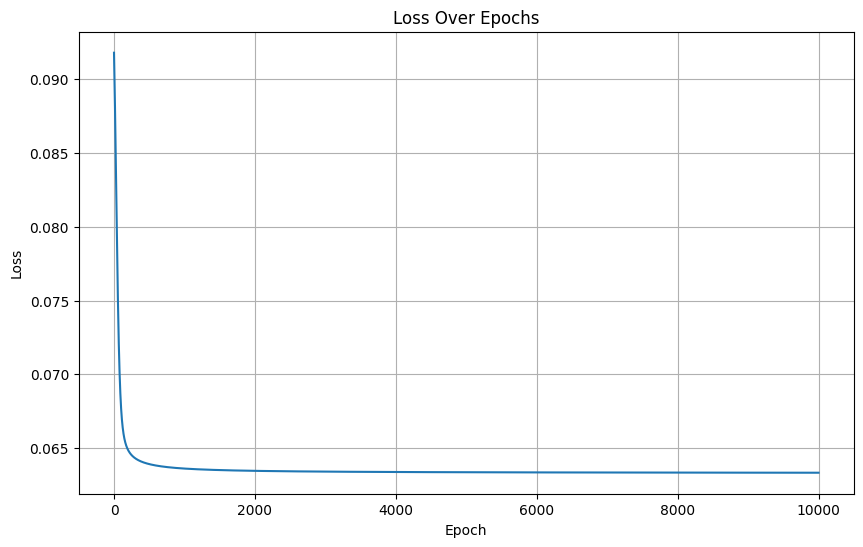

In [78]:
# Sample Exam
import matplotlib.pyplot as plt

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig_x = sigmoid(x)
    return sig_x * (1 - sig_x)

def identity(x):
    return x

def square(x):
    return x**2

def sine(x):
    return np.sin(x)

def cosine(x):
    return np.cos(x)

# AND problem dataset
X = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
y = np.array([[0], [0], [0], [1]])

# Initialize weights randomly
np.random.seed(42)  # For reproducibility
w1 = np.random.randn()  # Weight from x1 to hidden
w2 = np.random.randn()  # Weight from x2 to hidden
w3 = np.random.randn()  # Weight from bias to hidden
u1 = np.random.randn()  # Weight from x1 to output
v1 = np.random.randn()  # Weight from hidden to output

# Learning rate
learning_rate = 0.1

# Training parameters
epochs = 10000
loss_history = []

# Training loop
for epoch in range(epochs):
    total_loss = 0
    
    for i in range(len(X)):
        # Forward propagation
        x1 = X[i, 0]
        x2 = X[i, 1]
        bias = 1.0
        
        # First layer outputs
        f1_output = identity(x1)   # f1(x) = x
        f2_output = square(x2)     # f2(x) = x^2
        f3_output = identity(bias) # f3(x) = x = 1.0
        
        # Hidden layer
        hidden_input = w1 * f1_output + w2 * f2_output + w3 * f3_output
        hidden_output = sine(hidden_input)
        
        # Output layer
        output_input = u1 * f1_output + v1 * hidden_output
        output = sigmoid(output_input)
        
        # Calculate loss
        error = 0.5 * (output - y[i][0])**2
        total_loss += error
        
        # Backpropagation
        # Output layer gradient
        delta_output = (output - y[i][0]) * sigmoid_derivative(output_input)
        
        # Update weights
        # For u1 (direct connection from x1 to output)
        u1 -= learning_rate * delta_output * f1_output
        
        # For v1 (hidden to output)
        v1 -= learning_rate * delta_output * hidden_output
        
        # For w1, w2, w3 (connected to hidden layer)
        delta_hidden = delta_output * v1 * cosine(hidden_input)
        
        w1 -= learning_rate * delta_hidden * f1_output
        w2 -= learning_rate * delta_hidden * f2_output
        w3 -= learning_rate * delta_hidden * f3_output
    
    # Record average loss for this epoch
    avg_loss = total_loss / len(X)
    loss_history.append(avg_loss)
    
    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Testing the trained network
print("\nFinal weights:")
print(f"w1 = {w1:.6f}, w2 = {w2:.6f}, w3 = {w3:.6f}")
print(f"u1 = {u1:.6f}, v1 = {v1:.6f}")

print("\nTesting the AND problem:")
for i in range(len(X)):
    # Forward propagation with final weights
    x1 = X[i, 0]
    x2 = X[i, 1]
    bias = 1.0
    
    f1_output = identity(x1)
    f2_output = square(x2)
    f3_output = identity(bias)
    
    hidden_input = w1 * f1_output + w2 * f2_output + w3 * f3_output
    hidden_output = sine(hidden_input)
    
    output_input = u1 * f1_output + v1 * hidden_output
    output = sigmoid(output_input)
    
    print(f"Input: {x1}, {x2} | Target: {y[i][0]} | Predicted: {output:.6f} | Rounded: {round(output)}")

# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

### Bike Sharing Data

In [ ]:
df = pd.read_csv("../../data/day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [120]:
X = df.drop(["cnt", "instant", "dteday"], axis=1)
y = df["cnt"]

X.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1 )

#For purpose of Demonstration let's just use the default setting of the following models
LR = LinearRegression()
LR.fit(X_train, y_train)
Lasso = Lasso()
Lasso.fit(X_train, y_train)
Ridge1 = Ridge()
Ridge1.fit(X_train, y_train)
#kNN = KNeighborsRegressor(n_neighbors=8)
kNN = KNeighborsRegressor()
kNN.fit(X_train,y_train)
#SVR = Support Vecrtor Regression
SV=SVR(C=1.0, epsilon=0.2)
SV.fit(X_train,y_train)
#DT = DecisionTreeRegressor(max_depth=5)
DT = DecisionTreeRegressor()
DT.fit(X_train,y_train)
#RF = RandomForestRegressor(n_estimators = 100)
RF = RandomForestRegressor()
RF.fit(X_train,y_train)
#GBM = GradientBoostingRegressor(max_depth = 4, learning_rate=.1)
GBM = GradientBoostingRegressor()
GBM.fit(X_train,y_train)

y_pred_LR = LR.predict(X_test)
y_pred_Lasso = Lasso.predict(X_test)
y_pred_Ridge = Lasso.predict(X_test)
y_pred_kNN = DT.predict(X_test)
y_pred_SVR = SV.predict(X_test)
y_pred_DT = DT.predict(X_test)
y_pred_RF = RF.predict(X_test)
y_pred_GBM = GBM.predict(X_test)

cols = ['Machine Learning Regression Method','Train Accuracy', 'Test Accuracy']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = ['Linear Regression', LR.score(X_train, y_train), LR.score(X_test, y_test)]
df2.loc[1] = ['Linear Regression + Lasso', Lasso.score(X_train, y_train), Lasso.score(X_test, y_test)]
df2.loc[2] = ['Linear Regression + Ridge', Ridge1.score(X_train, y_train), Ridge1.score(X_test, y_test)]
df2.loc[3] = ['kNN', kNN.score(X_train, y_train), kNN.score(X_test, y_test)]
df2.loc[3] = ['Support Vector Regression', SV.score(X_train, y_train), SV.score(X_test, y_test)]
df2.loc[4] = ['Decision Tree',DT.score(X_train, y_train), DT.score(X_test, y_test)]
df2.loc[5] = ['Random Forest',RF.score(X_train, y_train), RF.score(X_test, y_test)]
df2.loc[6] = ['Gradient Boosting Method',GBM.score(X_train, y_train), GBM.score(X_test, y_test)]

df2

,Machine Learning Regression Method,Train Accuracy,Test Accuracy
0,Linear Regression,1.000000,1.000000
1,Linear Regression + Lasso,1.000000,1.000000
2,Linear Regression + Ridge,1.000000,1.000000
3,Support Vector Regression,0.073253,0.021387
4,Decision Tree,1.000000,0.991203
5,Random Forest,0.999371,0.995743
6,Gradient Boosting Method,0.999081,0.996804


In [123]:
param_grids = {'learning_rate': [.2, 0.05, 0.02, 0.01],
              'max_depth': [3, 4, 10, 14],
              'min_samples_leaf': [2,4],
              'max_features': [.5,.3, .2]
}

est = GradientBoostingRegressor(n_estimators=400)
gs_cv = GridSearchCV(est, param_grids, n_jobs=-1).fit(X_train, y_train)
print(gs_cv.best_params_)

{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 0.5, 'min_samples_leaf': 4}


In [124]:
y_GBM_gridsearch = gs_cv.predict(X_test)
gs_cv.score(X_test,y_test)

0.9949123441836949

In [127]:
# Define hyperparameters
learning_rate = 0.01
epochs = 1000
batch_size = 16

# Define the architecture of the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)  # No activation function for regression
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# Evaluate the model
y_pred=model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 10875719.0000 
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 107082.3984
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 5660.3594
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 1004.2438
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 793.1547
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 607.4488
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 349.3800
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 213.7483
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 131.9711
Epoch 10/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 83.0751
Epoch 11/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 66.5370
Epoch 12/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 74.2688
Epoch 13/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 35.8382
Epoch 14/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 35.